In [3]:
import yfinance as yf
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def normalize_prices(prices):
    """Normalize a price series by dividing it by its initial value.
    Returns the initial price so that we may de-normalize it later"""
    return prices / prices.iloc[0], prices.iloc[0]

In [5]:
def wavelet_decompose_pd(df: pd.DataFrame, column: str, wavelet='db1', level=None) -> pd.DataFrame:
    """
    Decompose a time series (Pandas DataFrame) into trend and noise components using Wavelet Transform.

    Args:
        df (pd.DataFrame): Input Pandas DataFrame with time series data.
        column (str): Column name to decompose.
        wavelet (str): Wavelet type (default: 'db1').
        level (int or None): Decomposition level (default: None).

    Returns:
        pd.DataFrame: Pandas DataFrame with 'trend' and 'noise' columns.
    """
    # Extract the series as a NumPy array
    series = df[column].to_numpy()

    # Perform wavelet decomposition
    coeffs = pywt.wavedec(series, wavelet, level=level)
    trend_coeffs = coeffs.copy()
    trend_coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # Zero out noise coefficients
    noise_coeffs = coeffs.copy()
    noise_coeffs[0] = np.zeros_like(coeffs[0])  # Zero out trend coefficients

    # Reconstruct trend and noise
    trend = pywt.waverec(trend_coeffs, wavelet)[:len(series)]
    noise = pywt.waverec(noise_coeffs, wavelet)[:len(series)]

    # Create and return a Pandas DataFrame with trend and noise
    result = pd.DataFrame({
        "Date": df["Date"],  # Keep original index or time column
        "Trend": trend,
        "Noise": noise
    })
    return result

In [6]:
# Fetch S&P 500 data
ticker = "SPY"
start_date = "2010-03-05"
end_date = "2018-03-15"
data = yf.download(ticker, start=start_date, end=end_date)
prices = data['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [7]:
# Renaming columns for simplicity
prices.reset_index(inplace=True)
prices.columns = ['Date', 'Adj Close']

In [8]:
# Decompose the series into trend and noise
results = wavelet_decompose_pd(prices, column='Adj Close', level=5)

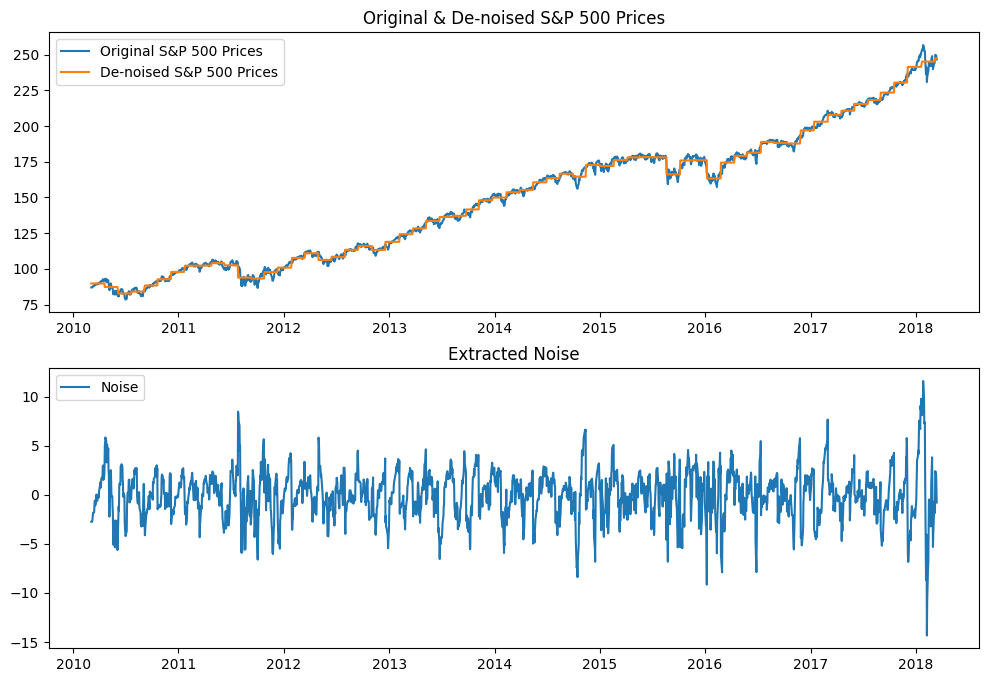

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# original & de-noised prices
axes[0].plot(prices['Date'], prices['Adj Close'], label='Original S&P 500 Prices')
axes[0].plot(results['Date'], results['Trend'], label='De-noised S&P 500 Prices')
axes[0].set_title('Original & De-noised S&P 500 Prices')
axes[0].legend()

# noise
axes[1].plot(results['Date'], results['Noise'], label='Noise')
axes[1].set_title('Extracted Noise')
axes[1].legend()

plt.tight_layout
plt.show()